In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [3]:
# -------------------------------
# 1. Load data
# -------------------------------
file="/content/drive/MyDrive/data.csv" #replace with file path
cancer_data = pd.read_csv(file)


In [5]:
# -------------------------------
# 2. Convert diagnosis labels: B -> 0, M -> 1
# -------------------------------
cancer_data["diagnosis"] = cancer_data["diagnosis"].map({"B":0, "M":1})

In [6]:
# -------------------------------
# 3. Subset malignant and benign
# -------------------------------
allMal = cancer_data[cancer_data["diagnosis"] == 1]
allBen = cancer_data[cancer_data["diagnosis"] == 0]


In [7]:
# -------------------------------
# 4. Split into training and test sets
# -------------------------------
np.random.seed(42)  # For reproducibility

# Randomly sample indices for test set (same as R's sample())
randomMal = np.random.choice(allMal.index, 40, replace=False)
randomBen = np.random.choice(allBen.index, 70, replace=False)

# Training set: drop sampled indices
cancer_training = pd.concat([
    allMal.drop(randomMal),
    allBen.drop(randomBen)
])

# Test set: only sampled indices
cancer_test = pd.concat([
    allMal.loc[randomMal],
    allBen.loc[randomBen]
])

# Reset index after concatenation
cancer_training = cancer_training.reset_index(drop=True)
cancer_test = cancer_test.reset_index(drop=True)

In [8]:
# -------------------------------
# 5. Train single-feature random forests
# -------------------------------
features = ["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean"]
cancer_rf_models = {}  # Dictionary to store models

for feature in features:
    # Initialize random forest with 500 trees
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    # Fit model on single feature
    rf.fit(cancer_training[[feature]], cancer_training["diagnosis"])
    # Store trained model
    cancer_rf_models[feature] = rf

In [9]:
# -------------------------------
# 6. Train full-feature random forest
# -------------------------------
features_all = features  # Use all four features
cancer_rf_all = RandomForestClassifier(n_estimators=500, random_state=42)
cancer_rf_all.fit(cancer_training[features_all], cancer_training["diagnosis"])


RandomForestClassifier(n_estimators=500, random_state=42)

In [10]:
# -------------------------------
# 7. Function to compute ROC, AUC, and confusion table
# -------------------------------
def evaluate_rf(model, feature_name, test_data, y_true):
    """
    Evaluate a random forest model:
    - Compute predicted probabilities
    - Plot ROC curve and compute AUC
    - Convert probabilities to 0/1 labels at 0.5 threshold
    - Generate confusion table
    """
    # Predicted probabilities for the positive class (Malignant)
    if isinstance(feature_name, str):
        y_score = model.predict_proba(test_data[[feature_name]])[:, 1]
    else:
        y_score = model.predict_proba(test_data[feature_name])[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({feature_name})')
    plt.legend(loc="lower right")
    plt.show()

    # Convert probabilities to predicted labels at 0.5 threshold
    pred_labels = np.array(["Ben"] * len(y_true))
    pred_labels[y_score > 0.5] = "Mal"

    # Confusion table (like R's table())
    confusion = pd.crosstab(pred_labels, test_data["diagnosis"])
    print(f"Confusion Table ({feature_name}):")
    print(confusion)
    print("\n")

    return y_score, roc_auc, confusion

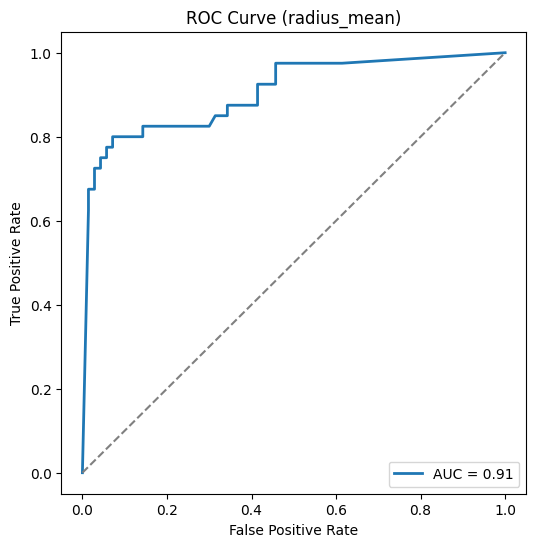

Confusion Table (radius_mean):
diagnosis   0   1
row_0            
Ben        58   7
Mal        12  33




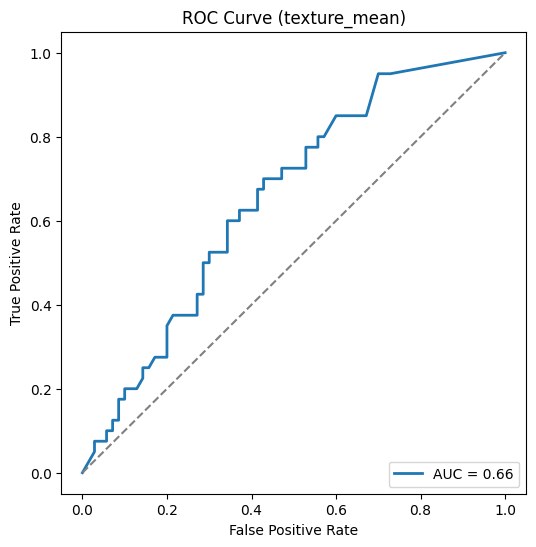

Confusion Table (texture_mean):
diagnosis   0   1
row_0            
Ben        51  25
Mal        19  15




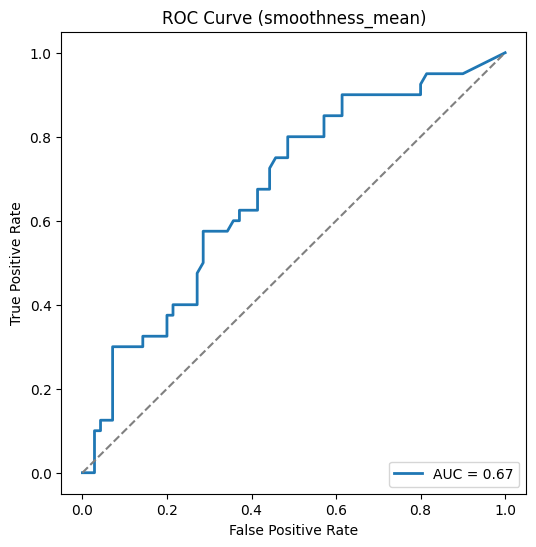

Confusion Table (smoothness_mean):
diagnosis   0   1
row_0            
Ben        54  24
Mal        16  16




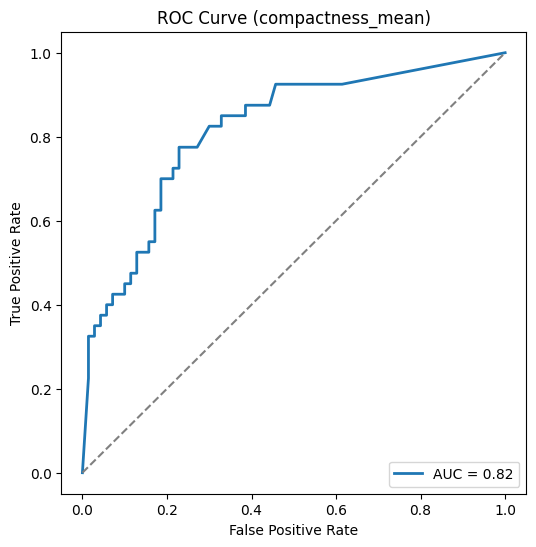

Confusion Table (compactness_mean):
diagnosis   0   1
row_0            
Ben        57  14
Mal        13  26




In [11]:
# -------------------------------
# 8. Evaluate single-feature models
# -------------------------------
y_true = cancer_test["diagnosis"].astype(int)

for feature in features:
    evaluate_rf(cancer_rf_models[feature], feature, cancer_test, y_true)

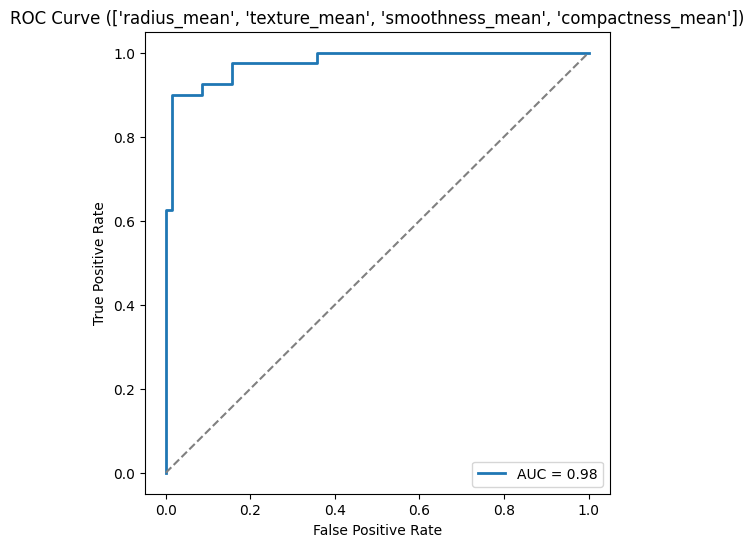

Confusion Table (['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean']):
diagnosis   0   1
row_0            
Ben        69   4
Mal         1  36




(array([0.998, 1.   , 0.986, 1.   , 0.976, 0.972, 0.984, 0.996, 0.86 ,
        0.964, 0.94 , 0.998, 0.994, 0.378, 0.854, 1.   , 0.97 , 0.992,
        0.894, 0.93 , 0.032, 0.998, 0.97 , 1.   , 1.   , 0.932, 1.   ,
        0.958, 0.242, 0.798, 0.982, 0.92 , 0.998, 0.552, 0.29 , 1.   ,
        0.938, 0.784, 0.978, 1.   , 0.018, 0.216, 0.018, 0.088, 0.02 ,
        0.352, 0.162, 0.01 , 0.   , 0.006, 0.   , 0.024, 0.008, 0.002,
        0.022, 0.152, 0.   , 0.056, 0.016, 0.   , 0.004, 0.01 , 0.002,
        0.014, 0.004, 0.018, 0.438, 0.102, 0.102, 0.482, 0.472, 0.002,
        0.054, 0.008, 0.   , 0.014, 0.314, 0.002, 0.004, 0.074, 0.022,
        0.01 , 0.004, 0.02 , 0.436, 0.   , 0.208, 0.   , 0.044, 0.002,
        0.474, 0.034, 0.314, 0.012, 0.004, 0.186, 0.006, 0.346, 0.   ,
        0.002, 0.   , 0.   , 0.002, 0.   , 0.002, 0.   , 0.372, 0.948,
        0.024, 0.122]),
 np.float64(0.9771428571428572),
 diagnosis   0   1
 row_0            
 Ben        69   4
 Mal         1  36)

In [12]:

# -------------------------------
# 9. Evaluate full-feature model
# -------------------------------
evaluate_rf(cancer_rf_all, features_all, cancer_test, y_true)
